In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.autonotebook import tqdm

import bandit.environment as env
from bandit.policy import EGreedy, Softmax
from bandit.torch import NeuralBandit, NeuralPerArmBandit, create_model

sns.set_theme()

/var/folders/7m/74_ct3hx33d878n626w1wxyc0000gn/T/ipykernel_15753/2096907171.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
N = 500

In [3]:
def run_simulation(bandit, policy=EGreedy(epsilon=0.0), n=N, dynamic=False):
    total_reward = 0
    avg_rewards = []
    rng = np.random.RandomState(42)

    for i in tqdm(range(n), disable=False):
        state = env.observe(rng)

        # 1. Predict the action.
        rewards = bandit.pull(state)

        action = policy(rewards)

        # 2. Act and get the reward.
        if dynamic and i > n // 2:
            get_cost = env.get_cost_new
        else:
            get_cost = env.get_cost
        reward = get_cost(state, env.actions[action])
        # Change reward to 0 or 1 instead of -1 or 1

        # 3. Update the model.
        bandit.update(state, action, reward)

        # 4. Save the reward.
        total_reward += max(0, reward)
        avg_rewards.append(total_reward / (i + 1))
    return avg_rewards, total_reward

In [4]:
bandit = NeuralBandit(n_arms=len(env.actions), batch=1)
# avg_rewards, total_reward = run_simulation(bandit, policy=Softmax(tau=0.1))
avg_rewards, total_reward = run_simulation(bandit)
total_reward

  0%|          | 0/500 [00:00<?, ?it/s]

222.0

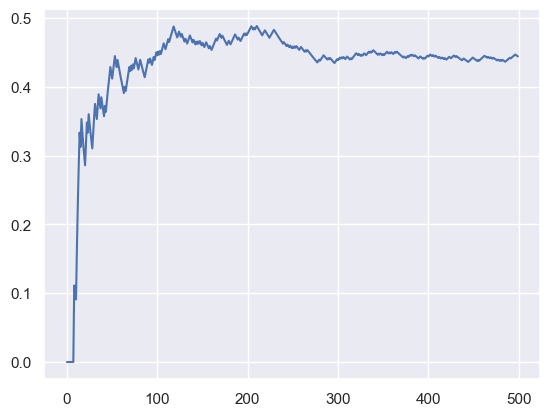

In [5]:
plt.plot(range(N), avg_rewards)

In [6]:
bandit = NeuralBandit(n_arms=len(env.actions), batch=1)
avg_rewards, total_reward = run_simulation(bandit, dynamic=True)
total_reward

  0%|          | 0/500 [00:00<?, ?it/s]

171.0

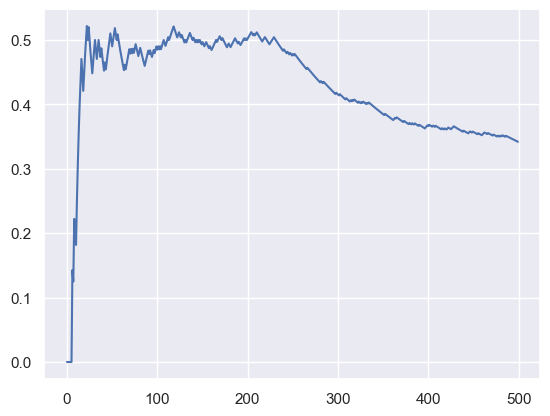

In [7]:
plt.plot(range(N), avg_rewards)

## Neural Per Arm Bandit - Static

In [8]:
bandit = NeuralPerArmBandit()
avg_rewards, total_reward = run_simulation(bandit)
total_reward

  0%|          | 0/500 [00:00<?, ?it/s]

479.0

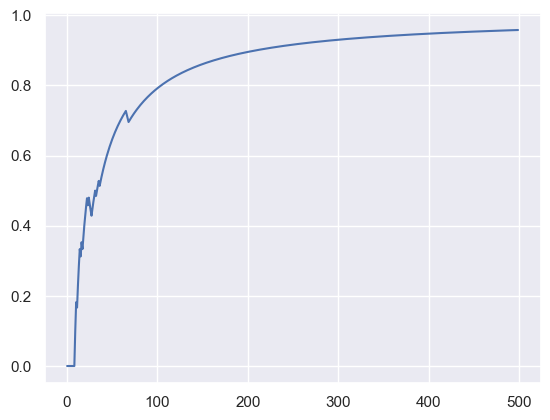

In [9]:
plt.plot(range(N), avg_rewards)

## Neural Per Arm Bandit - Dynamic

In [10]:
bandit = NeuralPerArmBandit()
avg_rewards, total_reward = run_simulation(bandit, dynamic=True)
total_reward

  0%|          | 0/500 [00:00<?, ?it/s]

447.0

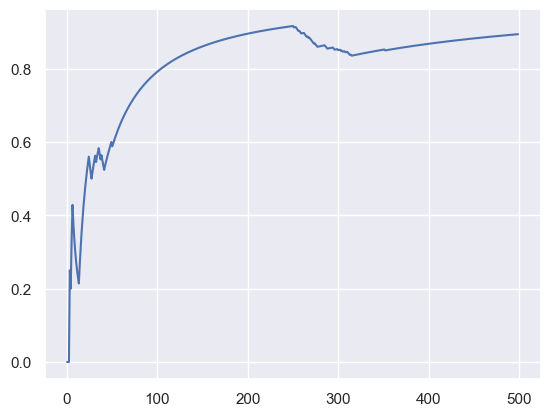

In [11]:
plt.plot(range(N), avg_rewards)

In [12]:
# bandit = NeuralBandit(n_arms=len(env.actions), batch=1)

# bandit = NeuralPerArmBandit()

policy = EGreedy(epsilon=0.0)
rng = np.random.RandomState(42)

for i in range(1):
    state = env.observe(rng)

    rewards = bandit.pull(state)
    print("rewards", rewards)

    action = policy(rewards)

    reward = env.get_cost(state, env.actions[action])
    print("action", action)
    print("reward", reward)

    # 3. Update the model.

    bandit.update(state, action, reward)

rewards [-1.2420452   0.9984168  -0.35861126 -0.46358806 -0.4326533  -0.46654683
 -0.5520654 ]
action 1
reward -1.0


## Conclusion

Per-arm bandit seems to be performing better, for unknown reasons. The feature-interaction doesn't seem to be doing its work when using torch or keras compared to scikit-learn's MLP.